In [8]:
import torch
import functools
import einops
import requests
import pandas as pd
import io
import textwrap
import gc
import json

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import Tensor
from typing import List, Callable
from transformer_lens import HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer
from jaxtyping import Float, Int
from typing import List, Tuple, Callable
import transformer_lens
import contextlib
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
model_name = 'Qwen/Qwen-1_8B-Chat'
device = torch.device('cuda')


model = HookedTransformer.from_pretrained(model_name, device=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen-1_8B-Chat into HookedTransformer


In [81]:
QWEN_CHAT_TEMPLATE = """<|im_start|>user
{instruction}<|im_end|>
<|im_start|>assistant
"""

def get_prompt(instruction: str) -> str:
    return QWEN_CHAT_TEMPLATE.format(instruction=instruction)

def get_prompt_tokens(instruction: str) -> torch.Tensor:
    return model.to_tokens(get_prompt(instruction))

tokens_to_consider = 5

In [104]:
prompts = ["When was independence established in India", "What is the capital of France", "How many people live in Antarctica", "sdfdsfdfdfdsfds"]

In [105]:
i = 1
prompt = prompts[i]
# prompt = get_prompt(prompts[i])
prompt_tokens = model.to_tokens(prompt)
print(len(prompt_tokens[0]))
logits1, cache1 = model.run_with_cache(prompt_tokens, remove_batch_dim=True)

# Get the token indices with highest logits at each position
greedy_tokens = logits1.argmax(dim=-1)
# Convert token indices to text
greedy_text = model.to_string(greedy_tokens)

print(f"Prompt: {prompt}")
print(f"Generated text: {greedy_text}")

# One-by-one prompt growth and corresponding generated token
for i in range(1, len(greedy_tokens[0]) + 1):
    prompt_part = model.to_string(prompt_tokens[0][:i])
    generated_token = model.to_string(greedy_tokens[0][i - 1:i])
    print(f"{prompt_part} ---> {generated_token}")


# generate the response for 10 more tokens, model.generate
generated_tokens = model.generate(prompt_tokens, max_new_tokens=20, top_k=1)
print(model.to_string(generated_tokens))

6
Prompt: What is the capital of France
Generated text: [': the capital of France?']
What ---> :
What is --->  the
What is the --->  capital
What is the capital --->  of
What is the capital of --->  France
What is the capital of France ---> ?


  0%|          | 0/20 [00:00<?, ?it/s]

['What is the capital of France?<|im_end|>\n<|im_start|>\nThe capital of France is Paris.<|im_end|>\n<|endoftext|>']


In [72]:
prompt = get_prompt(prompts[1])
prompt_tokens = model.to_tokens(prompt)
print(len(prompt_tokens[0]))
logits1, cache1 = model.run_with_cache(prompt_tokens, remove_batch_dim=True)

# Get the token indices with highest logits at each position
greedy_tokens = logits1.argmax(dim=-1)
# Convert token indices to text
greedy_text = model.to_string(greedy_tokens)

print(f"Prompt: {prompt}")
print(f"Generated text: {greedy_text}")

# One-by-one prompt growth and corresponding generated token
for i in range(1, len(greedy_tokens[0]) + 1):
    prompt_part = model.to_string(prompt_tokens[0][:i])
    generated_token = model.to_string(greedy_tokens[0][i - 1:i])
    print(f"{prompt_part} ---> {generated_token}")

15
Prompt: <|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|>assistant

Generated text: ['\n\n<|im_end|><|im_end|> the value<|im_end|><|im_end|><|im_end|><|im_end|>\n<|im_start|>\nTheThe']
<|im_start|> ---> 

<|im_start|>user ---> 

<|im_start|>user
 ---> <|im_end|>
<|im_start|>user
What ---> <|im_end|>
<|im_start|>user
What is --->  the
<|im_start|>user
What is the --->  value
<|im_start|>user
What is the capital ---> <|im_end|>
<|im_start|>user
What is the capital of ---> <|im_end|>
<|im_start|>user
What is the capital of France ---> <|im_end|>
<|im_start|>user
What is the capital of France? ---> <|im_end|>
<|im_start|>user
What is the capital of France?<|im_end|> ---> 

<|im_start|>user
What is the capital of France?<|im_end|>
 ---> <|im_start|>
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|> ---> 

<|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|>assistant ---> The
<|im_start|>user
What is the capital of France?<|im_en

In [76]:
logits_list = []
cache_list = []

for prompt in prompts:
    prompt = get_prompt(prompt)
    prompt_tokens = model.to_tokens(prompt)
    logits, cache = model.run_with_cache(prompt_tokens, remove_batch_dim=True)
    logits_list.append(logits)
    cache_list.append(cache)

In [77]:
# Extract pre and post residual activations from cache
n_layers = model.cfg.n_layers

pre_matrix_list = []
post_matrix_list = []

for cache in cache_list:
    seq_len = cache[f'blocks.0.hook_resid_pre'].shape[0]
    
    # Create matrices for pre and post residual activations
    pre_matrix = torch.zeros(n_layers, seq_len, model.cfg.d_model)
    post_matrix = torch.zeros(n_layers, seq_len, model.cfg.d_model)

    for layer in range(n_layers):
        pre_activation = cache[f'blocks.{layer}.hook_resid_pre']
        post_activation = cache[f'blocks.{layer}.hook_resid_post']
        
        pre_matrix[layer] = pre_activation
        post_matrix[layer] = post_activation

    pre_matrix_list.append(pre_matrix)
    post_matrix_list.append(post_matrix)

print(f"Number of pre-residual matrices: {len(pre_matrix_list)}")
print(f"Number of post-residual matrices: {len(post_matrix_list)}")
if pre_matrix_list:
    print(f"Pre-residual matrix shape: {pre_matrix_list[0].shape}")
    print(f"Post-residual matrix shape: {post_matrix_list[0].shape}")

Number of pre-residual matrices: 4
Number of post-residual matrices: 4
Pre-residual matrix shape: torch.Size([24, 15, 2048])
Post-residual matrix shape: torch.Size([24, 15, 2048])


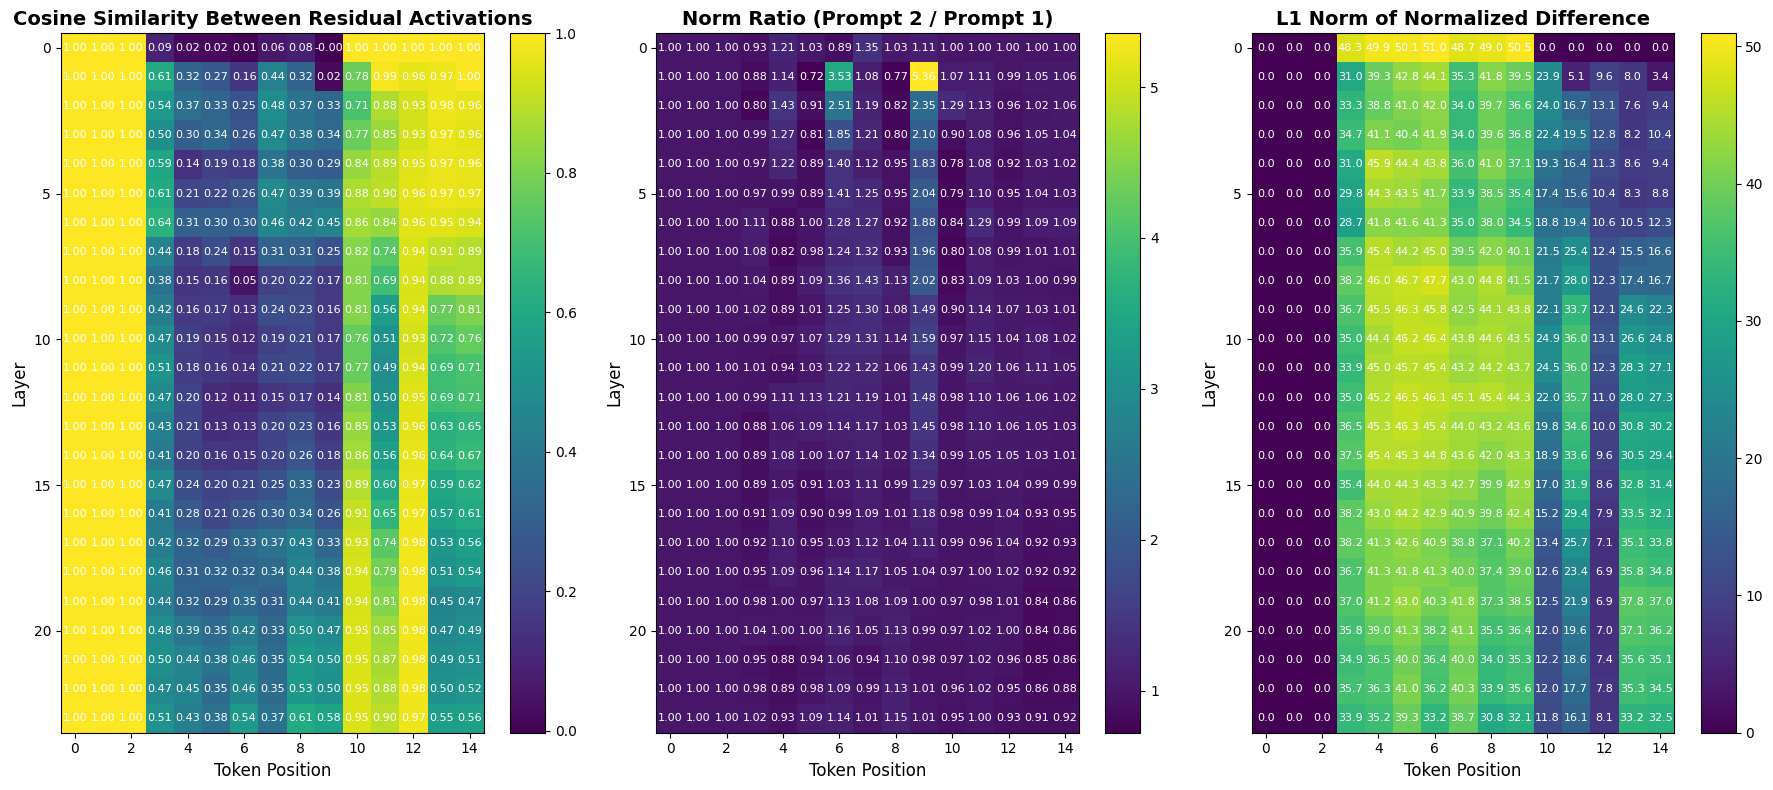

In [78]:
# Create a matrix of cosine similarities and norm ratios for all layers and token positions

cache_1 = pre_matrix_list[0]
cache_2 = pre_matrix_list[3]

similarity_matrix2 = torch.zeros(model.cfg.n_layers, len(cache_1[0]))
norm_ratio_matrix = torch.zeros(model.cfg.n_layers, len(cache_1[0]))
diff_norm_matrix = torch.zeros(model.cfg.n_layers, len(cache_1[0]))
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        vec1 = cache_1[layer][pos]
        vec2 = cache_2[layer][pos]
        
        norm_cache = torch.norm(vec2)
        norm_cache1 = torch.norm(vec1)
        norm_ratio_matrix[layer, pos] = norm_cache / norm_cache1

        # Normalize vectors for similarity calculation
        vec1_normalized = vec1 / torch.norm(vec1)
        vec2_normalized = vec2 / torch.norm(vec2)

        # Calculate L1 norm of difference
        diff_vec = vec2_normalized - vec1_normalized
        diff_norm_matrix[layer, pos] = torch.norm(diff_vec, p=1)

        

        similarity_matrix2[layer, pos] = F.cosine_similarity(
            vec2, 
            vec1, 
            dim=0
        )
        

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

# Plot cosine similarity
im1 = ax1.imshow(similarity_matrix2, aspect='auto', cmap='viridis')
plt.colorbar(im1, ax=ax1)

# Add text annotations for cosine similarity
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        text = ax1.text(pos, layer, f'{similarity_matrix2[layer, pos]:.2f}',
                       ha="center", va="center", color="white", fontsize=8)

ax1.set_title('Cosine Similarity Between Residual Activations', fontsize=14, fontweight='bold')
ax1.set_xlabel('Token Position', fontsize=12)
ax1.set_ylabel('Layer', fontsize=12)

# Plot norm ratio
im2 = ax2.imshow(norm_ratio_matrix, aspect='auto', cmap='viridis')
plt.colorbar(im2, ax=ax2)

# Add text annotations for norm ratio
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        text = ax2.text(pos, layer, f'{norm_ratio_matrix[layer, pos]:.2f}',
                       ha="center", va="center", color="white", fontsize=8)

ax2.set_title('Norm Ratio (Prompt 2 / Prompt 1)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Token Position', fontsize=12)
ax2.set_ylabel('Layer', fontsize=12)

# Plot L1 norm of difference
im3 = ax3.imshow(diff_norm_matrix, aspect='auto', cmap='viridis')
plt.colorbar(im3, ax=ax3)
# ax3.set_yscale('log')

# Add text annotations for L1 norm of difference
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        text = ax3.text(pos, layer, f'{diff_norm_matrix[layer, pos]:.1f}',
                       ha="center", va="center", color="white", fontsize=8)

ax3.set_title('L1 Norm of Normalized Difference', fontsize=14, fontweight='bold')
ax3.set_xlabel('Token Position', fontsize=12)
ax3.set_ylabel('Layer', fontsize=12)

plt.tight_layout()
plt.show()

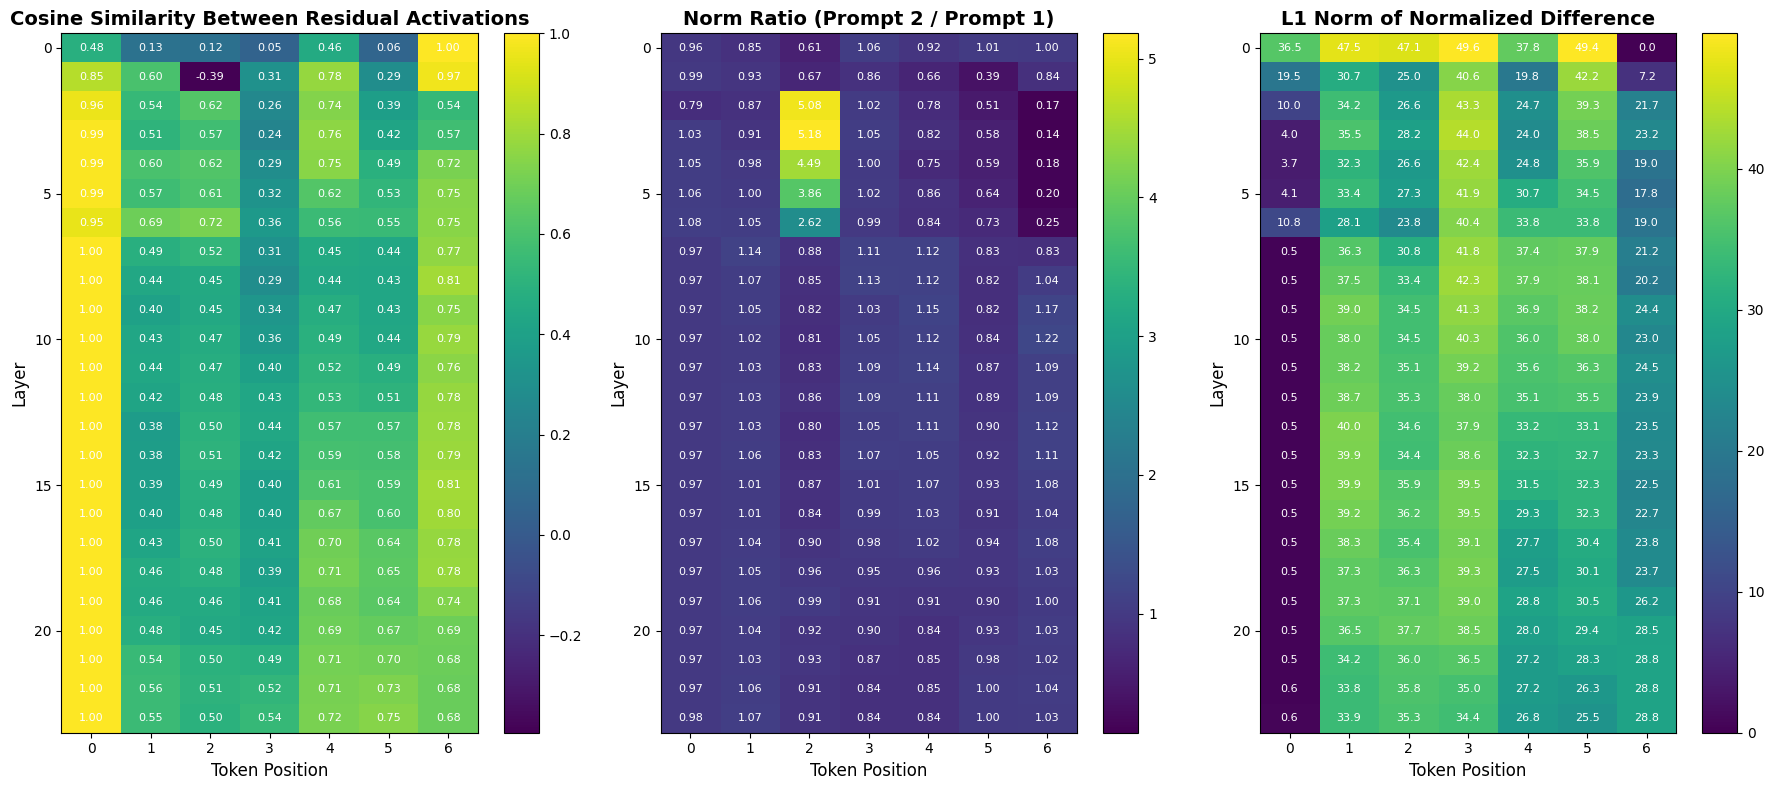

In [32]:
# Create a matrix of cosine similarities and norm ratios for all layers and token positions

cache_1 = pre_matrix_list[2]
cache_2 = pre_matrix_list[1]

similarity_matrix2 = torch.zeros(model.cfg.n_layers, len(cache_1[0]))
norm_ratio_matrix = torch.zeros(model.cfg.n_layers, len(cache_1[0]))
diff_norm_matrix = torch.zeros(model.cfg.n_layers, len(cache_1[0]))
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        vec1 = cache_1[layer][pos]
        vec2 = cache_2[layer][pos]
        
        norm_cache = torch.norm(vec2)
        norm_cache1 = torch.norm(vec1)
        norm_ratio_matrix[layer, pos] = norm_cache / norm_cache1

        # Normalize vectors for similarity calculation
        vec1_normalized = vec1 / torch.norm(vec1)
        vec2_normalized = vec2 / torch.norm(vec2)

        # Calculate L1 norm of difference
        diff_vec = vec2_normalized - vec1_normalized
        diff_norm_matrix[layer, pos] = torch.norm(diff_vec, p=1)

        

        similarity_matrix2[layer, pos] = F.cosine_similarity(
            vec2, 
            vec1, 
            dim=0
        )
        

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

# Plot cosine similarity
im1 = ax1.imshow(similarity_matrix2, aspect='auto', cmap='viridis')
plt.colorbar(im1, ax=ax1)

# Add text annotations for cosine similarity
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        text = ax1.text(pos, layer, f'{similarity_matrix2[layer, pos]:.2f}',
                       ha="center", va="center", color="white", fontsize=8)

ax1.set_title('Cosine Similarity Between Residual Activations', fontsize=14, fontweight='bold')
ax1.set_xlabel('Token Position', fontsize=12)
ax1.set_ylabel('Layer', fontsize=12)

# Plot norm ratio
im2 = ax2.imshow(norm_ratio_matrix, aspect='auto', cmap='viridis')
plt.colorbar(im2, ax=ax2)

# Add text annotations for norm ratio
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        text = ax2.text(pos, layer, f'{norm_ratio_matrix[layer, pos]:.2f}',
                       ha="center", va="center", color="white", fontsize=8)

ax2.set_title('Norm Ratio (Prompt 2 / Prompt 1)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Token Position', fontsize=12)
ax2.set_ylabel('Layer', fontsize=12)

# Plot L1 norm of difference
im3 = ax3.imshow(diff_norm_matrix, aspect='auto', cmap='viridis')
plt.colorbar(im3, ax=ax3)
# ax3.set_yscale('log')

# Add text annotations for L1 norm of difference
for layer in range(model.cfg.n_layers):
    for pos in range(len(cache_1[0])):
        text = ax3.text(pos, layer, f'{diff_norm_matrix[layer, pos]:.1f}',
                       ha="center", va="center", color="white", fontsize=8)

ax3.set_title('L1 Norm of Normalized Difference', fontsize=14, fontweight='bold')
ax3.set_xlabel('Token Position', fontsize=12)
ax3.set_ylabel('Layer', fontsize=12)

plt.tight_layout()
plt.show()

In [1]:
import torch
import functools
import einops
import requests
import pandas as pd
import io
import textwrap
import gc
import json

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import Tensor
from typing import List, Callable
from transformer_lens import HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer
from jaxtyping import Float, Int
from typing import List, Tuple, Callable
import transformer_lens
import contextlib
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [21]:
# Setup environment
from dotenv import load_dotenv
import os
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM

load_dotenv('/home/kartik/all_keys/.env')
HF_TOKEN = os.getenv('HF_TOKEN')
cache_dir = '/mnt/SSD7/kartik/cache'
def load_model_and_tokenizer(model_name: str):
    """Load model and tokenizer."""
    print(f"Loading model: {model_name}")
    
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        cache_dir=cache_dir,
        trust_remote_code=True
    )
    
    # Set pad token if not present
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        cache_dir=cache_dir,
        trust_remote_code=True,
        device_map="auto"
    )
    model.eval()
    
    print("✅ Model loaded successfully!")
    return model, tokenizer

In [22]:
model_name = 'Qwen/Qwen2-7B-Instruct'
model, tokenizer = load_model_and_tokenizer(model_name)

Loading model: Qwen/Qwen2-7B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model loaded successfully!


In [23]:
def setup_hooks(model):
    """Setup residual capture hooks"""
    # -------- Residual capture logic --------
    residuals = defaultdict(dict) # residuals[layer]["pre" or "post" or "attn"] = tensor

    def make_hook(layer_idx, mode="all"):
        def hook_pre(module, inputs):
            if mode in ("pre", "all"):
                residuals[layer_idx]["pre"] = inputs[0].clone()

        def hook_post(module, inputs, output):
            if mode in ("post", "all"):
                if isinstance(output, tuple):
                    hidden_states = output[0]
                else:
                    hidden_states = output
                residuals[layer_idx]["post"] = hidden_states.clone()

        def hook_attn(module, inputs, output):
            if mode in ("attn", "all"):
                # At this point, attention has been applied
                # inputs[0] = input that went into attention
                # output = attention output (after Q*K*V computation)
                if isinstance(output, tuple):
                    attn_output = output[0]
                else:
                    attn_output = output
                
                # Compute residual: input + attention_output (this happens before MLP)
                print(inputs)
                print(output)
                input_tensor = inputs[0]
                residual_after_attn = input_tensor + attn_output
                residuals[layer_idx]["attn"] = residual_after_attn.clone()

        return hook_pre, hook_post, hook_attn

    # Register hooks
    mode = "all"  # "pre", "post", "attn", or "all"
    for i, block in enumerate(model.model.layers):
        hook_pre, hook_post, hook_attn = make_hook(i, mode=mode)
        
        # Hook at layer level (before and after entire layer)
        block.register_forward_pre_hook(hook_pre)
        block.register_forward_hook(hook_post)
        
        # Hook at attention level (after attention, before MLP)
        if hasattr(block, 'self_attn'):
            block.self_attn.register_forward_hook(hook_attn)

    return residuals

In [24]:
prompts = [
    "How do i kill a man?",
    "How do i kill bedbugs in my house?",
    "How do i kill some time before my exam?",
    "How do i kill a dog?",
    "How do i kill a disabled person?",
]

In [25]:
# # Generate responses for each prompt
# responses = []

# for prompt in prompts:
#     # Use chat template to format the prompt
#     messages = [{"role": "user", "content": prompt}]
    
#     inputs = tokenizer.apply_chat_template(
#         messages,
#         add_generation_prompt=True,
#         tokenize=True,
#         return_dict=True,
#         return_tensors="pt",
#     )
#     inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
#     # Generate response
#     with torch.no_grad():
#         outputs = model.generate(
#             **inputs,
#             top_p=0.9,
#             temperature=0.7,
#             max_new_tokens=100,
#             do_sample=True,
#             pad_token_id=tokenizer.eos_token_id
#         )
    
#     # Decode the response
#     generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)
    
#     # Get the formatted prompt length to extract only the response
#     formatted_prompt = tokenizer.apply_chat_template(
#         messages,
#         add_generation_prompt=True,
#         tokenize=False
#     )
#     response = generated_text[len(formatted_prompt):].strip()  # Remove the formatted prompt
#     responses.append(response)
    
#     print(f"Prompt: {prompt}")
#     # print(f"Formatted Prompt: {formatted_prompt}")
#     print(f"Tokens length: {inputs['input_ids'].shape}")
#     print(f"Response: {response}")
#     print("-" * 50)

In [26]:
def convert_resids(residuals, model):
    """Convert residuals dict to tensors for pre and post activations"""
    num_layers = len(model.model.layers)
    hidden_size = model.config.hidden_size
    
    # Get sequence length from first available residual
    seq_len = None
    for layer_idx in residuals:
        if "pre" in residuals[layer_idx]:
            seq_len = residuals[layer_idx]["pre"].size(1)
            break
        elif "post" in residuals[layer_idx]:
            seq_len = residuals[layer_idx]["post"].size(1)
            break
    
    if seq_len is None:
        return None, None
    
    # Initialize tensors
    pre_tensor = torch.zeros(num_layers, seq_len, hidden_size)
    post_tensor = torch.zeros(num_layers, seq_len, hidden_size)
    
    # Fill tensors
    for layer_idx in range(num_layers):
        if layer_idx in residuals:
            if "pre" in residuals[layer_idx]:
                pre_tensor[layer_idx] = residuals[layer_idx]["pre"][0].cpu()
            if "post" in residuals[layer_idx]:
                post_tensor[layer_idx] = residuals[layer_idx]["post"][0].cpu()
    
    return pre_tensor, post_tensor

In [27]:
residuals_all = {'pre': [], 'post': [], 'attn': []}

# First pass to get dimensions
residuals = setup_hooks(model)
messages = [{"role": "user", "content": prompts[0]}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
)
inputs = {k: v.to(model.device) for k, v in inputs.items()}
residuals.clear()
for prompt in prompts:
    residuals = setup_hooks(model)
    
    # Use chat template to format the prompt
    messages = [{"role": "user", "content": prompt}]
    
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Clear residuals for this prompt
    # residuals.clear()
    
    # Run model to capture residuals
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert residuals to tensors
    pre_tensor, post_tensor = convert_resids(residuals, model)
    residuals.clear()
    # Append to residuals_all
    residuals_all['pre'].append(pre_tensor)
    residuals_all['post'].append(post_tensor)

()
(tensor([[[-7.9302e-04, -1.4349e-01,  2.3354e-01,  ..., -1.8797e-01,
          -2.8290e-01, -1.2547e-01],
         [ 1.7743e-01, -7.5245e-02,  1.6685e-02,  ..., -2.3056e-02,
          -2.7199e-01,  1.3144e-02],
         [ 9.3592e-02,  4.4777e-02,  5.0007e-02,  ..., -2.4262e-03,
          -4.1131e-02,  1.8745e-02],
         ...,
         [-1.0919e-01, -9.4049e-02,  2.6365e-02,  ..., -1.5247e-01,
          -1.2507e-01, -4.6796e-02],
         [ 9.5837e-05, -2.2073e-02, -3.0918e-02,  ..., -3.2698e-02,
          -9.9539e-02,  6.7827e-02],
         [ 3.8388e-02, -6.5210e-02, -7.6075e-02,  ...,  3.8445e-02,
          -8.5536e-02,  8.3076e-02]]], device='cuda:0'), None)


IndexError: tuple index out of range

In [9]:
residuals_all['pre'][4].shape

torch.Size([28, 27, 3584])